In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel, ViTConfig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import gc

In [2]:
# Paths
train_path = '/content/drive/MyDrive/New Plant Disease Dataset(Augmented)/train'
valid_path = '/content/drive/MyDrive/New Plant Disease Dataset(Augmented)/valid'

# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduce input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_path, transform=valid_transforms)
print(f"Number of classes: {len(train_data.classes)}")
print(f"Classes: {train_data.classes}")
print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(valid_data)}")

# Data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Number of classes: 5
Classes: ['Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Number of training images: 3750
Number of validation images: 750


Epoch 1, Train Accuracy: 46.08%, Validation Accuracy: 53.33%
Epoch 2, Train Accuracy: 57.28%, Validation Accuracy: 61.87%
Epoch 3, Train Accuracy: 63.95%, Validation Accuracy: 68.00%
Epoch 4, Train Accuracy: 72.29%, Validation Accuracy: 72.53%
Epoch 5, Train Accuracy: 78.29%, Validation Accuracy: 77.87%
Epoch 6, Train Accuracy: 82.88%, Validation Accuracy: 82.67%
Epoch 7, Train Accuracy: 86.56%, Validation Accuracy: 83.47%
Epoch 8, Train Accuracy: 88.43%, Validation Accuracy: 86.13%
Epoch 9, Train Accuracy: 89.04%, Validation Accuracy: 86.67%
Epoch 10, Train Accuracy: 90.32%, Validation Accuracy: 87.47%


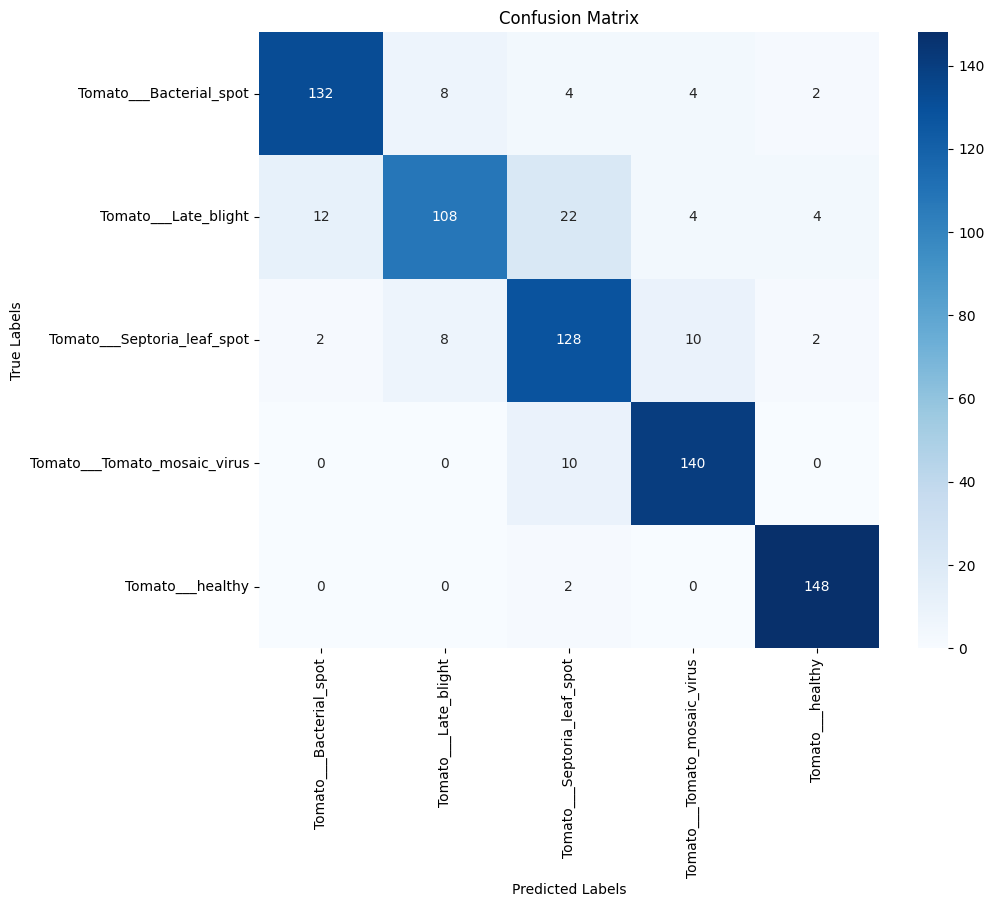



                              precision    recall  f1-score   support

     Tomato___Bacterial_spot       0.90      0.88      0.89       150
        Tomato___Late_blight       0.87      0.72      0.79       150
 Tomato___Septoria_leaf_spot       0.77      0.85      0.81       150
Tomato___Tomato_mosaic_virus       0.89      0.93      0.91       150
            Tomato___healthy       0.95      0.99      0.97       150

                    accuracy                           0.87       750
                   macro avg       0.88      0.87      0.87       750
                weighted avg       0.88      0.87      0.87       750




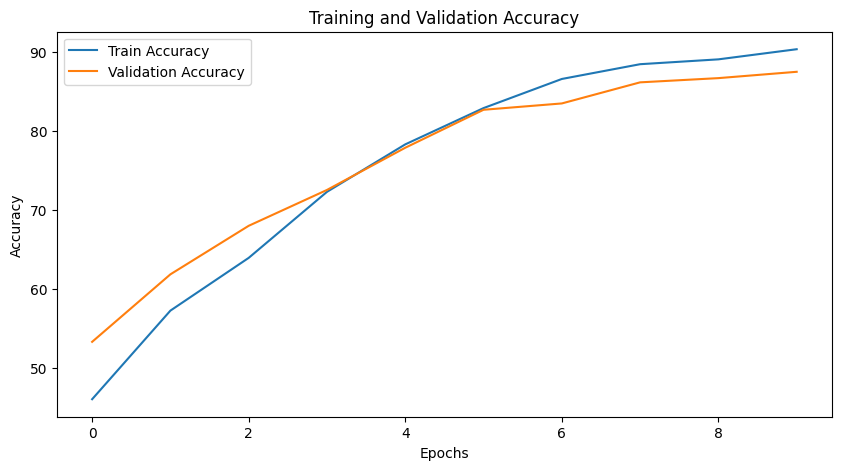

In [4]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification
config = ViTConfig.from_pretrained("WinKawaks/vit-tiny-patch16-224")
vit_model = ViTModel(config)

# Custom model
class CustomModel(nn.Module):
    def __init__(self, vit_model):
        super(CustomModel, self).__init__()
        self.vit_model = vit_model
        self.fc = nn.Linear(config.hidden_size, 5)

    def forward(self, x):
        outputs = self.vit_model(x).pooler_output
        x = self.fc(outputs)
        return x

model = CustomModel(vit_model)

# Freeze all layers and unfreeze the classifier and last few transformer layers
for param in vit_model.parameters():
    param.requires_grad = False
for param in vit_model.encoder.layer[-2:].parameters():  # Unfreeze last 2 transformer layers
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': vit_model.encoder.layer[-2:].parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

# Mixed precision training setup
scaler = torch.amp.GradScaler('cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training and validation
num_epochs = 10
accumulation_steps = 4
best_accuracy = 0.0
train_accuracies = []  # Initialize train_accuracies here
valid_accuracies = []  # Initialize valid_accuracies here

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels) / accumulation_steps
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_accuracy = 100 * correct_val / total_val
    train_accuracies.append(train_accuracy)  # Append train accuracy to the list
    valid_accuracies.append(val_accuracy)  # Append validation accuracy to the list
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    torch.cuda.empty_cache()
    gc.collect()

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print()
print()

print(classification_report(all_labels, all_preds, target_names=train_data.classes))
print()

# Training plots
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


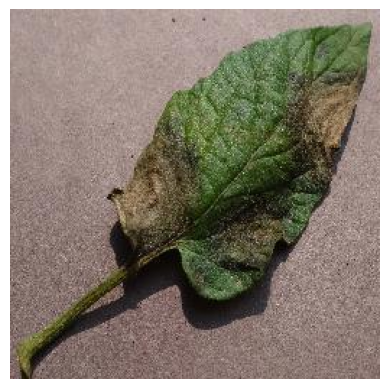

The predicted disease type is: Tomato___Late_blight


In [25]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTConfig  # Add this import

# Define the class names as per your training dataset
class_names = [
    "Tomato___Bacterial_spot",  "Tomato___Late_blight",
    "Tomato___Septoria_leaf_spot", "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy"
]

# Data transformations for the test image
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the trained model
class CustomModel(nn.Module):
    def __init__(self, vit_model):
        super(CustomModel, self).__init__()
        self.vit_model = vit_model
        self.fc = nn.Linear(vit_model.config.hidden_size, len(class_names))

    def forward(self, x):
        outputs = self.vit_model(x).pooler_output
        x = self.fc(outputs)
        return x

# Configuration for ViT
config = ViTConfig.from_pretrained("WinKawaks/vit-tiny-patch16-224")
vit_model = ViTModel(config)
model = CustomModel(vit_model)

# Load the trained model weights
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu'), weights_only=True))
model.eval()

# Function to predict the disease type from an image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = test_transforms(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_name = class_names[predicted.item()]
    return class_name

# Test the model with an example image
image_path = '/content/drive/MyDrive/New Plant Disease Dataset(Augmented)/test/IMG (12).JPG'
disease_type = predict_image(image_path)
print(f'The predicted disease type is: {disease_type}')
